# Build a retweet network

- Hydroxychloroquine data : all tweets with "chloroquine" in it
- in French


## Load the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../../Données/df_hcq_fr_total_rt_date_2020_2023.parquet")

In [8]:
df.head()

,id,created_at,from_user_name,text,lang,to_user_name,to_user_id,in_reply_to_status_id,from_user_id,from_user_realname,...,retweeted_id,retweeted_user_name,retweeted_user_id,quoted_id,quoted_user_name,quoted_user_id,links,mentioned_user_names,hashtags,nb_retweets
28,1356029770019045378,2021-02-01 00:01:05,citoyennedu47,RT @Ecolophobe: Un nouveau médoc qui fait auss...,fr,None,None,None,826846693639540741,citoyenne 47/matricule 10578😤,...,1355987622854799364,Ecolophobe,2423405008,None,None,None,https://twitter.com/silvano_trotta/status/1355...,ecolophobe,None,NaN
32,1356029835173388296,2021-02-01 00:01:21,47hopestreet,RT @La_Dame_du_LAC1: La chloroquine puissant i...,fr,None,None,None,959345332315357184,InZenity.,...,1355985778158030849,La_Dame_du_LAC1,781866817539244032,None,None,None,None,la_dame_du_lac1,None,NaN
33,1356029855004037121,2021-02-01 00:01:25,LouiseTrezor,RT @VirusWar: La première version de cet artic...,fr,None,None,None,1263838528879951872,louise Trezor,...,1355857291392786433,VirusWar,2366128891,None,None,None,None,viruswar,coronavirus|hydroxychloroquine,NaN
43,1356029985186787330,2021-02-01 00:01:56,NANARomain2,RT @NicolasPichot6: 🔴The American Journal of M...,fr,None,None,None,1301902793054261249,Le peuple cogite!,...,1355977630701518852,NicolasPichot6,1323747268013527041,None,None,None,https://rumble.com/vdffhx-peer-reviewed-journa...,adv_in21|complotisss|nicolaspichot6,None,NaN
64,1356030184240132096,2021-02-01 00:02:44,CERCLEDIMIER,RT @JuliaCerisi: Livraison d'hydroxychloroquin...,fr,None,None,None,698209631970045954,CERCLE LOUIS DIMIER,...,1356000819276034048,JuliaCerisi,391920857,1355969788808466433,MarguerinT,1311744414558171138,None,juliacerisi,None,NaN


Have a look to the columns

In [7]:
df.columns

Index(['id', 'created_at', 'from_user_name', 'text', 'lang', 'to_user_name',
       'to_user_id', 'in_reply_to_status_id', 'from_user_id',
       'from_user_realname', 'from_user_description', 'from_user_tweetcount',
       'from_user_followercount', 'from_user_friendcount',
       'from_user_created_at', 'collected_via_thread_only',
       'collected_at_timestamp', 'retweeted_id', 'retweeted_user_name',
       'retweeted_user_id', 'quoted_id', 'quoted_user_name', 'quoted_user_id',
       'links', 'mentioned_user_names', 'hashtags', 'nb_retweets'],
      dtype='object')

each tweet or retweet is defined by an id, a user who created it (a bio), a date, it can bet either an original tweet, a retweet (there is a retweet_id), a quote or an answer. Each element is defined by a text (which can contains hashtags and urls)

### Explore the dataset

<Axes: >

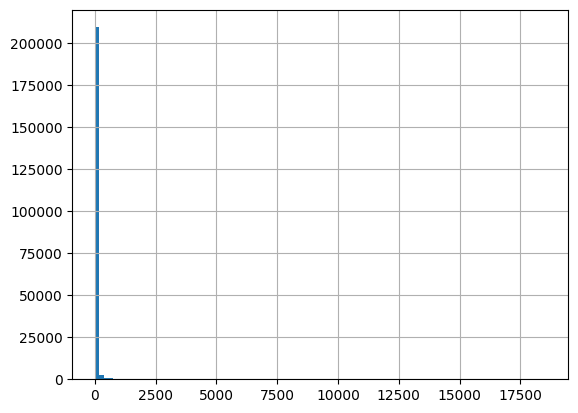

In [21]:
df["nb_retweets"].dropna().hist(bins=100)

### Evolution on the period

Original tweets and retweets

<Axes: xlabel='created_at'>

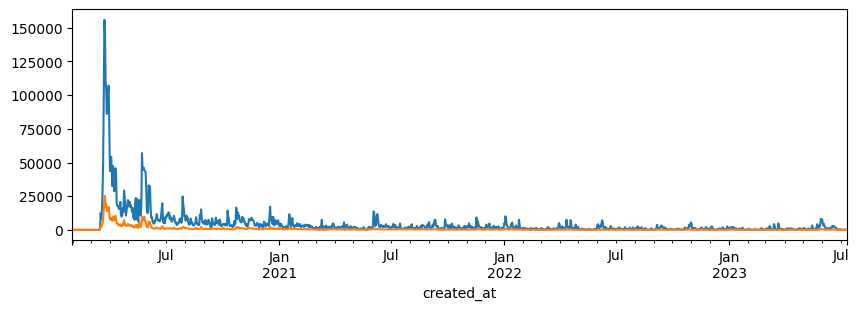

In [27]:
ax = df.set_index("created_at")["id"].resample("d").count().plot(figsize=(10,3))

df[df["retweeted_id"].isnull()].set_index("created_at")["id"]\
            .resample("d").count().plot(figsize=(10,3),
                                                                                                 ax=ax)

### To summarize

- actions that be tweet or retweet
- a retweet is a tweet which is shared by a user
- it connects the user who created the tweet and the user who shared it

we can make the hypothesis that retweets are a proxy of agreement regarding an information

## Let's build a network of proximity betweets Twitter users using retweet as a measure of agreement/proximity

We are going to build a network with networkx

- each node is a twitter user who spoke about HCQ
- each edge represent the retweet relation between two accounts
- we add a feature "weight" for the nodes which reprsents how much they were active on twitter (tweet or retweet)
- we add a feature "weight" for edges wich represents how much a user retweeted another one

Let's do that for one day

In [28]:
day = "2020-04-20"

In [34]:
f = (df["created_at"] > "2020-04-19") & (df["created_at"] < "2020-04-21")

In [37]:
df_sample = df[f]

### Build the network

In [62]:
import networkx as nx

network = nx.Graph()

for i,j in df_sample.iterrows():
    
    # create nodes of the network
    user_name = j["from_user_name"]
    if network.has_node(user_name):
        network.nodes[user_name]["weight"]+=1
    else:
        network.add_node(user_name, 
                        label=user_name, 
                        weight=1)
        
    # create edges for each retweet
    if pd.notnull(j["retweeted_user_name"]): # si c'est un retweet
        retweeted_user = j["retweeted_user_name"]
        
        # add the retweeted user name
        if not network.has_node(retweeted_user):
            network.add_node(retweeted_user, 
                        label=retweeted_user, 
                        weight=0)            
        
        # increase the weight or create the edge
        if network.has_edge(user_name, retweeted_user):
            network.edges[user_name, retweeted_user]["weight"]+=1
        else:
            network.add_edge(user_name, retweeted_user, weight=1)

In [63]:
print(reseau)

Graph with 12264 nodes and 14427 edges
